In [105]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from matplotlib.dates import date2num, num2date
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob
import sklearn as skl
from sklearn.utils.extmath import randomized_svd
#import dask
from matplotlib import style
import EOF_funcs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
import GA_cofine
from  importlib  import reload

Reading the data, if surface.nc exists, read it, if not read the subset, select surface layer and replace NaN with interpolation in time. 

In [106]:
filenm='Data/surface_.nc'
try:
    print('Read:'+filenm)
    surface=xr.open_dataset(filenm)
except:
    print('Cannot find:'+filenm)
    print('Creating...')
    data=xr.open_dataset('byfjordenSubset.nc')
    data.close()
    surface=data.isel(depth=0).sel(Y=slice(6733400,6737500),X=slice(-40000,-35000)).isel(depth=0)
    surface['u']=surface.u.interpolate_na(dim='time')
    surface['v']=surface.v.interpolate_na(dim='time')
    surface.to_netcdf(filenm)



Read:Data/surface_.nc


Text(0.5, 1.0, 'Standard deviation v velocity')

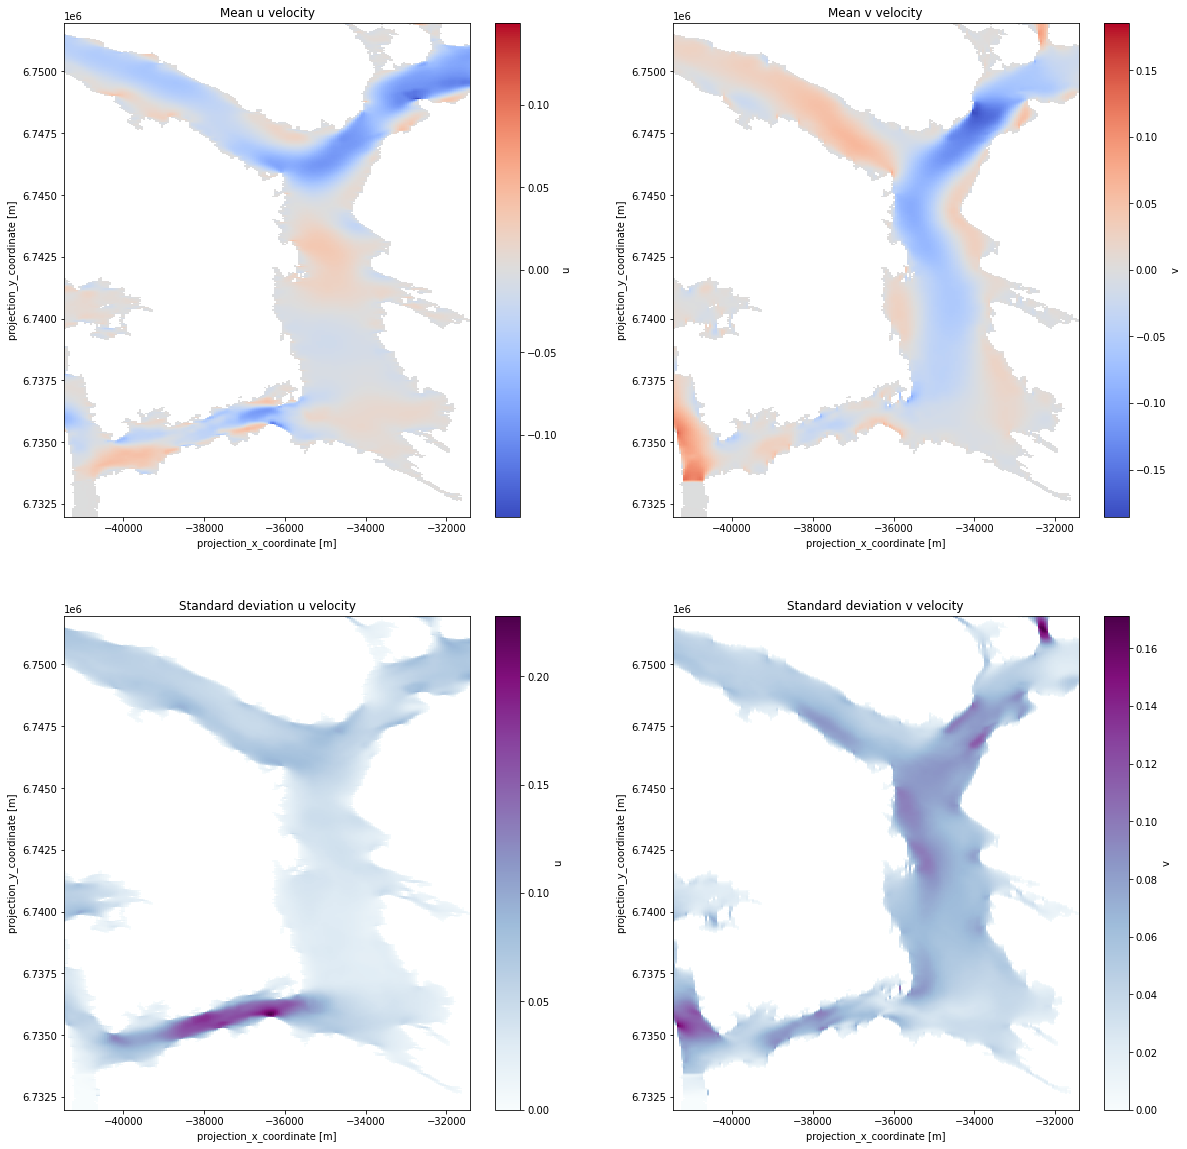

In [107]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
cmap='coolwarm'
cmap_std='BuPu'
surface.u.mean(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
surface.v.mean(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
surface.u.std(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
surface.v.std(dim='time').where(surface.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


Text(0.5, 1.0, 'Correlation u and v')

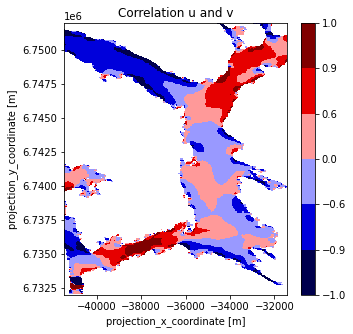

In [108]:
fig, axes = plt.subplots(ncols=1, figsize=(5,5))
xr.corr(surface.u,surface.v,dim='time').plot(vmin=-1,vmax=1,levels=[-1,-0.9,-0.6,0,0.6,0.9,1],cmap='seismic',ax=axes)
axes.set_title('Correlation u and v')


In [113]:
surface

<xarray.Dataset>
Dimensions:           (time: 1501, Y: 400, X: 201)
Coordinates:
  * X                 (X) float32 -4.144e+04 -4.139e+04 ... -3.144e+04
  * Y                 (Y) float32 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
    depth             float32 ...
  * time              (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-1...
Data variables:
    u                 (time, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    v                 (time, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    h                 (Y, X) float32 ...
    projection_stere  float32 ...
    land_binary_mask  (Y, X) float32 1.0 1.0 1.0 1.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    Conventions:  CF-1.6
    title:        Datasett Masteroppgave

In [187]:
u=(surface.u-surface.u.mean(dim='time')).stack(z=['Y','X'])
v=(surface.v-surface.v.mean(dim='time')).stack(z=['Y','X'])
mask=surface.land_binary_mask.stack(z=['Y','X']).data


In [214]:
u=u.where(mask==0).dropna(dim='z')
v=v.where(mask==0).dropna(dim='z')

In [221]:
u

<xarray.DataArray 'u' (time: 1501, z: 28375)>
array([[ 0.        ,  0.        ,  0.        , ..., -0.02588583,
        -0.01555325, -0.00711583],
       [ 0.        ,  0.        ,  0.        , ...,  0.02682247,
         0.01100792,  0.00126332],
       [ 0.        ,  0.        ,  0.        , ...,  0.041154  ,
         0.01572918,  0.00141894],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.04060754,
        -0.01997854, -0.00331806],
       [ 0.        ,  0.        ,  0.        , ..., -0.03389946,
        -0.01707827, -0.00321537],
       [ 0.        ,  0.        ,  0.        , ..., -0.04315104,
        -0.02561713, -0.00737917]], dtype=float32)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04

In [215]:
C=u.data.T@v.data
N=10
random_state=0

In [216]:
U,L,Vt=randomized_svd(C,N,random_state=random_state)

In [217]:
A=u.data@U
B=v.data@Vt.T


In [218]:
res=xr.Dataset(coords=u.coords)

res['U']=(('z','mode'),U)
res['V']=(('z','mode'),Vt.T)
res['L']=(('mode'),L)
res['A']=(('time','mode'),A)
res['B']=(('time','mode'),B)
res

<xarray.Dataset>
Dimensions:  (time: 1501, z: 28375, mode: 10)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Dimensions without coordinates: mode
Data variables:
    U        (z, mode) float32 -2.032e-11 -7.17e-08 ... -0.001364 -0.0005357
    V        (z, mode) float32 -3.396e-11 -2.135e-07 ... -0.006337 -0.004502
    L        (mode) float32 3.316e+04 1.923e+04 ... 1.124e+03 1.029e+03
    A        (time, mode) float32 10.33 3.136 3.11 -0.6676 ... 1.156 1.13 1.439
    B        (time, mode) float32 7.25 4.125 0.3916 ... 0.05498 -0.1681 2.147

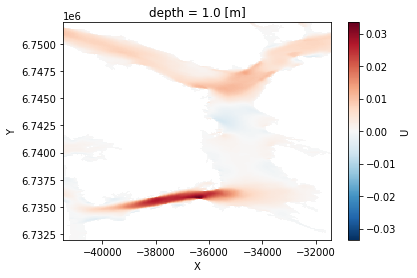

In [219]:
res.U.isel(mode=0).unstack('z').plot()

In [223]:
res['usvd']=(('time','z'),res.A.data@res.U.data.T)
res['vsvd']=(('time','z'),res.B.data@res.V.data.T)
res['u']=u
res['v']=v
res

<xarray.Dataset>
Dimensions:  (time: 1501, z: 28375, mode: 10)
Coordinates:
    depth    float32 1.0
  * time     (time) datetime64[ns] 2010-03-27T16:00:00 ... 2010-07-16T18:40:00
  * z        (z) MultiIndex
  - Y        (z) float64 6.732e+06 6.732e+06 6.732e+06 ... 6.752e+06 6.752e+06
  - X        (z) float64 -4.124e+04 -4.119e+04 ... -3.219e+04 -3.214e+04
Dimensions without coordinates: mode
Data variables:
    U        (z, mode) float32 -2.032e-11 -7.17e-08 ... -0.001364 -0.0005357
    V        (z, mode) float32 -3.396e-11 -2.135e-07 ... -0.006337 -0.004502
    L        (mode) float32 3.316e+04 1.923e+04 ... 1.124e+03 1.029e+03
    A        (time, mode) float32 10.33 3.136 3.11 -0.6676 ... 1.156 1.13 1.439
    B        (time, mode) float32 7.25 4.125 0.3916 ... 0.05498 -0.1681 2.147
    usvd     (time, z) float32 -3.941e-06 1.674e-07 ... -0.02478 -0.007006
    vsvd     (time, z) float32 -6.877e-07 -3.737e-07 ... 0.05592 -0.008635
    u        (time, z) float32 0.0 0.0 0.0 0.0 ... -0.04315 -0.02562 -0.007379
    v        (time, z) float32 0.0 0.0 0.0 0.0 ... 0.03503 0.03074 0.01637

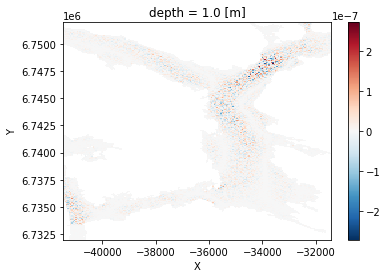

In [202]:
(res.vsvd-v).mean(dim='time').unstack('z').plot()

In [207]:
res[['A','B','U','V']].unstack('z').to_netcdf('test.nc')

In [224]:
res[['u','v']].unstack('z').to_netcdf('testu.nc')

## Cross corr fine-coarse

In [109]:
HRdata=surface.sel(Y=slice(6733400,6737500),X=slice(-40000,-35000))

Text(0.5, 1.0, 'Standard deviation v velocity')

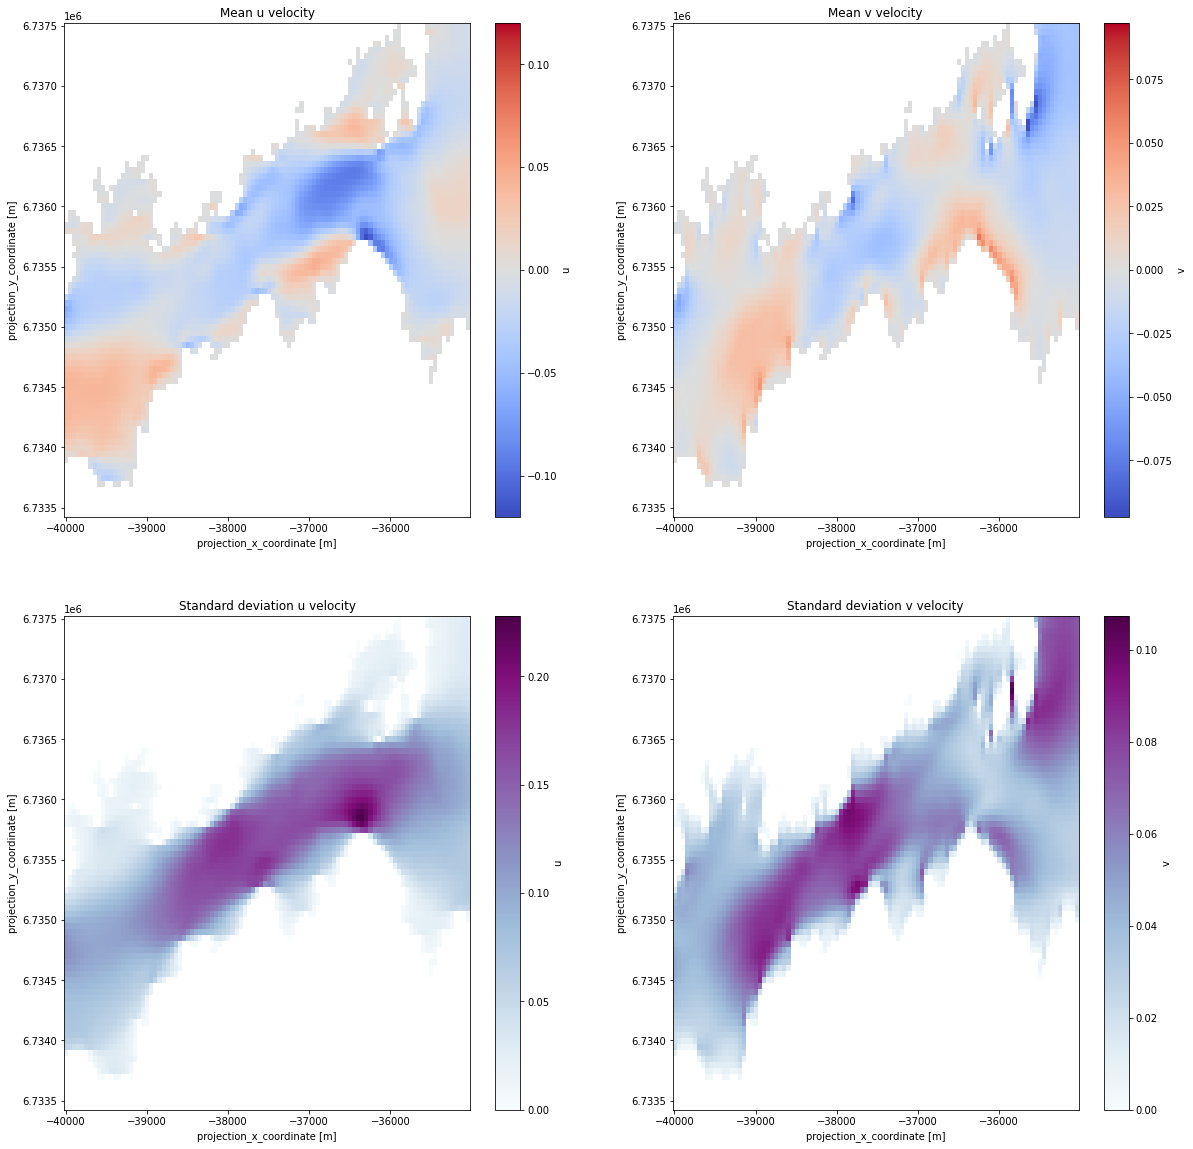

In [110]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
cmap='coolwarm'
cmap_std='BuPu'
HRdata.u.mean(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
HRdata.v.mean(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
HRdata.u.std(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
HRdata.v.std(dim='time').where(HRdata.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


In [111]:
yname='Y'
xname='X'
skip=6
LRdata=HRdata.isel(Y=slice(0,HRdata.dims[yname],skip),X=slice(0,HRdata.dims[xname],skip))

Text(0.5, 1.0, 'Standard deviation v velocity')

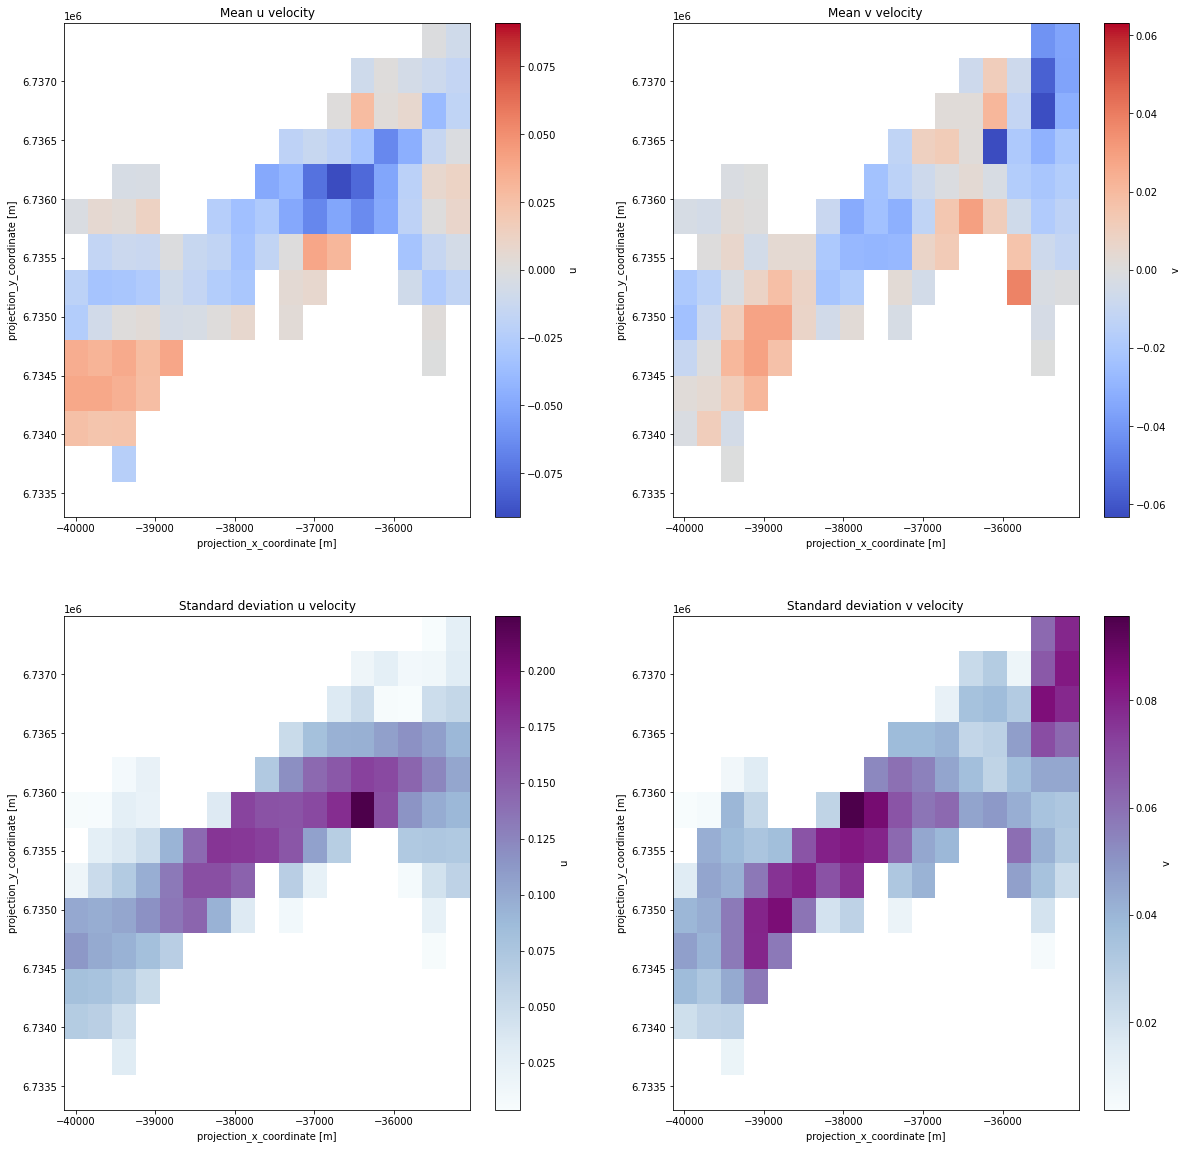

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
cmap='coolwarm'
cmap_std='BuPu'
LRdata.u.mean(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[0,0],cmap=cmap)
axes[0,0].set_title('Mean u velocity')
LRdata.v.mean(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[0,1],cmap=cmap)
axes[0,1].set_title('Mean v velocity')
LRdata.u.std(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[1,0],cmap=cmap_std)
axes[1,0].set_title('Standard deviation u velocity')
LRdata.v.std(dim='time').where(LRdata.land_binary_mask==0).plot(ax=axes[1,1],cmap=cmap_std)
axes[1,1].set_title('Standard deviation v velocity')


In [225]:
def create_vel(data):
    data['vel']=xr.concat([data['u'],data['v']] ,dim='comp')
    data=data.stack(z=['comp','Y','X'])
    data=data.where(data.land_binary_mask==0,drop=True).dropna(dim='time')
    return data

def norm_vel(data):
    out=((data-data.mean(dim='time')))#/data.std(dim='time'))
    return out.dropna(dim='z')
#LRvel=xr.concat([LRdata['u'],LRdata['v']] ,dim='comp')

In [226]:
HRvel=create_vel(HRdata)['vel']
LRvel=create_vel(LRdata)['vel']

In [227]:
HRnorm=norm_vel(HRvel)
LRnorm=norm_vel(LRvel)

In [228]:
C=(1/1500)*HRnorm.data.T@LRnorm.data

In [235]:
U,L,Vt = np.linalg.svd(C)
V=Vt.T

U=U[:,0:10]
V=V[:,0:10]
L=L[0:10]

In [240]:
A=HRnorm.data@U
B=LRnorm.data@V

In [247]:
uf=xr.DataArray(A@U.T,coords=HRnorm.coords)
vf=xr.DataArray(B@V.T,coords=LRnorm.coords)


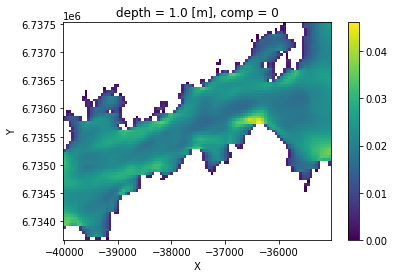

In [254]:
(uf-HRnorm).std(dim='time').unstack('z').isel(comp=0).plot()

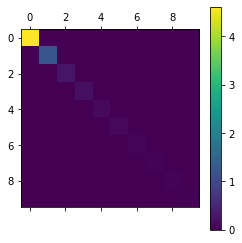

In [261]:
plt.matshow((A-A.mean(axis=0)).T@(B-B.mean(axis=0))/1500)
plt.colorbar()